# **Maximizing Annual Memberships for Cyclistic Bike-Share: A Data-Driven Approach**

## Import the necessary libraries

In [97]:
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from scipy import stats
from geopy.distance import geodesic

## Bikeshare Dataset list

In [2]:
# get list of bike_share .csv files in the 'bike_share' folder
bikeshare_list = os.listdir('bike_share') 

# print list of bike_share .csv files
print(bikeshare_list)

['202101-divvy-tripdata.csv', '202102-divvy-tripdata.csv', '202103-divvy-tripdata.csv', '202104-divvy-tripdata.csv', '202105-divvy-tripdata.csv', '202106-divvy-tripdata.csv', '202107-divvy-tripdata.csv', '202108-divvy-tripdata.csv', '202109-divvy-tripdata.csv', '202110-divvy-tripdata.csv', '202111-divvy-tripdata.csv', '202112-divvy-tripdata.csv']


## Clean and prepare data

In [3]:
def clean_data(bikeshare_list):
    """
    Cleans the bikeshare data and saves the results to a new CSV file.
    """

    # specify the path to the folder containing raw bike_share files
    raw = 'bike_share'

    for index, df_path in enumerate(bikeshare_list):
        # read in data 
        try:
            df = pd.read_csv(os.path.join(raw, df_path))
            print(df.shape)
        except:
            print(f'Error reading {df_path}')
            break
            
        # remove duplicates    
        df.drop_duplicates(inplace=True)
        
        # fill missing values in start and end station columns with unknownwith 'unknown'
        df['start_station_name'].fillna('unknown', inplace=True)
        df['end_station_name'].fillna('unknown', inplace=True)
        
        # fill missing values in latitude and longitude columns with mean values
        df['start_lat'].fillna(df['start_lat'].mean(), inplace=True)
        df['start_lng'].fillna(df['start_lng'].mean(), inplace=True)
        df['end_lat'].fillna(df['end_lat'].mean(), inplace=True)
        df['end_lng'].fillna(df['end_lng'].mean(), inplace=True)
        
        # convert started_at and ended_at columns to datetime objects
        try:
            if (df['started_at'].dtypes != 'datetime64[ns]') & (df['ended_at'].dtypes != 'datetime64[ns]'):
                df['started_at'] = pd.to_datetime(df['started_at'], format='%Y-%m-%d %H:%M:%S')
                df['ended_at'] = pd.to_datetime(df['ended_at'], format='%Y-%m-%d %H:%M:%S')
            else:
                print(f'datetime columns in {df_path} are of correct datatype')
                continue
        except:
            print(f'Error converting datetime columns in {df_path}')
            break

        # specify the path to the folder
        folder_path = 'bike_share_clean'

        # create the folder if it does not exist
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        # save the clean data to the specified folder
        df.to_csv(os.path.join(folder_path, df_path[:-4] + '-clean.csv'), index=False)

        # print success message
        print(f"{index}, {os.path.join(folder_path, df_path[:-4] + '-clean.csv')} is saved successfully!")

clean_data(bikeshare_list)

(96834, 13)
0, bike_share_clean\202101-divvy-tripdata-clean.csv is saved successfully!
(49622, 13)
1, bike_share_clean\202102-divvy-tripdata-clean.csv is saved successfully!
(228496, 13)
2, bike_share_clean\202103-divvy-tripdata-clean.csv is saved successfully!
(337230, 13)
3, bike_share_clean\202104-divvy-tripdata-clean.csv is saved successfully!
(531633, 13)
4, bike_share_clean\202105-divvy-tripdata-clean.csv is saved successfully!
(729595, 13)
5, bike_share_clean\202106-divvy-tripdata-clean.csv is saved successfully!
(822410, 13)
6, bike_share_clean\202107-divvy-tripdata-clean.csv is saved successfully!
(804352, 13)
7, bike_share_clean\202108-divvy-tripdata-clean.csv is saved successfully!
(756147, 13)
8, bike_share_clean\202109-divvy-tripdata-clean.csv is saved successfully!
(631226, 13)
9, bike_share_clean\202110-divvy-tripdata-clean.csv is saved successfully!
(359978, 13)
10, bike_share_clean\202111-divvy-tripdata-clean.csv is saved successfully!
(247540, 13)
11, bike_share_clean

## Merge the dataset into one

In [3]:
# specify the path to the folder
folder_path = 'bike_share_clean'

# List all dataset in the 'bike_share_clean' folder for the twelve months
clean_data = os.listdir(folder_path)

In [4]:
# Load the first month dataset
df1 = pd.read_csv(os.path.join(folder_path, clean_data[0]))

# Load the second month dataset
df2 = pd.read_csv(os.path.join(folder_path, clean_data[1]))

# Load the third month dataset
df3 = pd.read_csv(os.path.join(folder_path, clean_data[2]))

# Load the fourth month dataset
df4 = pd.read_csv(os.path.join(folder_path, clean_data[3]))

# Load the fifth month dataset
df5 = pd.read_csv(os.path.join(folder_path, clean_data[4]))

# Load the sixth month dataset
df6 = pd.read_csv(os.path.join(folder_path, clean_data[5]))

# Load the seventh month dataset
df7 = pd.read_csv(os.path.join(folder_path, clean_data[6]))

# Load the eighth month dataset
df8 = pd.read_csv(os.path.join(folder_path, clean_data[7]))

# Load the nineth month dataset
df9 = pd.read_csv(os.path.join(folder_path, clean_data[8]))

# Load the tenth month dataset
df10 = pd.read_csv(os.path.join(folder_path, clean_data[9]))

# Load the eleventh month dataset
df11 = pd.read_csv(os.path.join(folder_path, clean_data[10]))

# Load the twelveth month dataset
df12 = pd.read_csv(os.path.join(folder_path, clean_data[11]))

In [5]:
# Unite the twelve datasets
df_union = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12])

## Validate that data is clean

### Check for missing values

In [6]:
# Check for missing values
missing = df_union.isnull().sum()
print(missing)

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name         0
start_station_id      682181
end_station_name           0
end_station_id        728893
start_lat                  0
start_lng                  0
end_lat                    0
end_lng                    0
member_casual              0
dtype: int64


We only have missing values in `start_station_id` and `end_station_id`, and we wouldn't be needing these columns for our analysis, thus we can drop them.

In [7]:
# Drop `start_station_id` and `end_station_id` columns
df_union.drop(['start_station_id', 'end_station_id'], axis=1, inplace=True)

### Check for duplicates

In [8]:
# Check for duplicates
duplicates = df_union.duplicated().sum()
print(duplicates)

0


### Check for correct datatype

In [9]:
# Inspect datatype of df_union
df_union.dtypes

ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
end_station_name       object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
dtype: object

`started_at` and `ended_at` columns are of object datatype instead of datatime[ms]. We need to covert them to datetime datatype

In [10]:
# convert started_at and ended_at columns to datetime objects
df_union['started_at'] = pd.to_datetime(df_union['started_at'], format='%Y-%m-%d %H:%M:%S')
df_union['ended_at'] = pd.to_datetime(df_union['ended_at'], format='%Y-%m-%d %H:%M:%S')

In [11]:
# Re-inspect datatype of df_union
df_union.dtypes

ride_id                       object
rideable_type                 object
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
end_station_name              object
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual                 object
dtype: object

### Check for data quality

In [12]:
# Check for date completeness (Jan - Dec 2021)
# for `started_at` and `ended_at`
completeness_s = df_union['started_at'].dt.month_name().unique()
completeness_e = df_union['ended_at'].dt.month_name().unique()

print(completeness_s)
print(completeness_e)

['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August'
 'September' 'October' 'November' 'December']
['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August'
 'September' 'October' 'November' 'December']


## Exploratory Data Analysis

### Q1. How do annual members and casual riders use Cyclistic bikes differently?

#### Duration of the ride and Stations:

We start by analyzing the `member_casual` column, comparing the usage patterns of annual members and casual riders by looking at the `started_at` and `ended_at` columns to see how long each group tends to take their rides, as well as the `start_station_name` and `end_station_name` columns to see which stations they tend to start and end their rides at.

In [13]:
# Calculate the average ride duration for annual members and casual riders
annual_members_avg_duration = df_union[df_union['member_casual'] == 'member']['ended_at'].subtract(df_union[df_union['member_casual'] == 'member']['started_at']).mean()
casual_riders_avg_duration = df_union[df_union['member_casual'] == 'casual']['ended_at'].subtract(df_union[df_union['member_casual'] == 'casual']['started_at']).mean()

# Calculate the most popular start and end stations for annual members and casual riders
annual_members_start_stations = df_union[(df_union['member_casual'] == 'member') & (df_union['start_station_name'] != 'unknown')]['start_station_name'].value_counts().head(5)
annual_members_end_stations = df_union[(df_union['member_casual'] == 'member') & (df_union['end_station_name'] != 'unknown')]['end_station_name'].value_counts().head(5)
casual_riders_start_stations = df_union[(df_union['member_casual'] == 'casual') & (df_union['start_station_name'] != 'unknown')]['start_station_name'].value_counts().head(5)
casual_riders_end_stations = df_union[(df_union['member_casual'] == 'casual') & (df_union['end_station_name'] != 'unknown')]['end_station_name'].value_counts().head(5)

# Print the results
print(f"Annual members average ride duration: {annual_members_avg_duration}")
print(f"Casual riders average ride duration: {casual_riders_avg_duration}")
print(f"Annual members most popular start stations:\n{annual_members_start_stations}")

Annual members average ride duration: 0 days 00:13:37.969958820
Casual riders average ride duration: 0 days 00:32:00.056884822
Annual members most popular start stations:
Clark St & Elm St           24740
Wells St & Concord Ln       23718
Kingsbury St & Kinzie St    23565
Wells St & Elm St           21022
Dearborn St & Erie St       19585
Name: start_station_name, dtype: int64


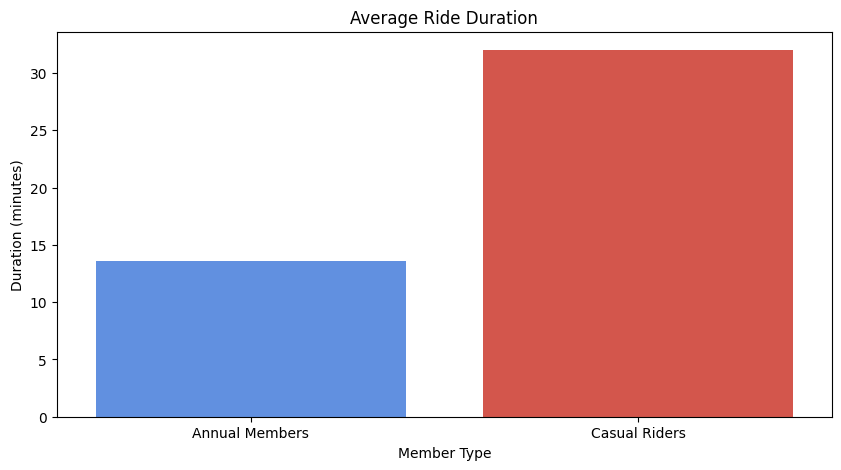

In [14]:
# Set the figure size
plt.figure(figsize=(10, 5))

# Plot the average ride duration for annual members and casual riders
sns.barplot(x=['Annual Members', 'Casual Riders'], y=[annual_members_avg_duration.total_seconds()/60, casual_riders_avg_duration.total_seconds()/60], palette=['#4C8BF5','#EA4335'])
plt.title('Average Ride Duration')
plt.xlabel('Member Type')
plt.ylabel('Duration (minutes)')
plt.show()

**Notes:**

The average ride duration for annual members is about 13 minutes and 37 seconds, while the average ride duration for casual riders is about 32 minutes. This indicates that, on average, annual members tend to take shorter bike rides than casual riders. 

This could be due to a variety of factors, such as the purpose of the ride (e.g. commuting vs. leisure) or the type of bike (e.g. electric, classic or docked).

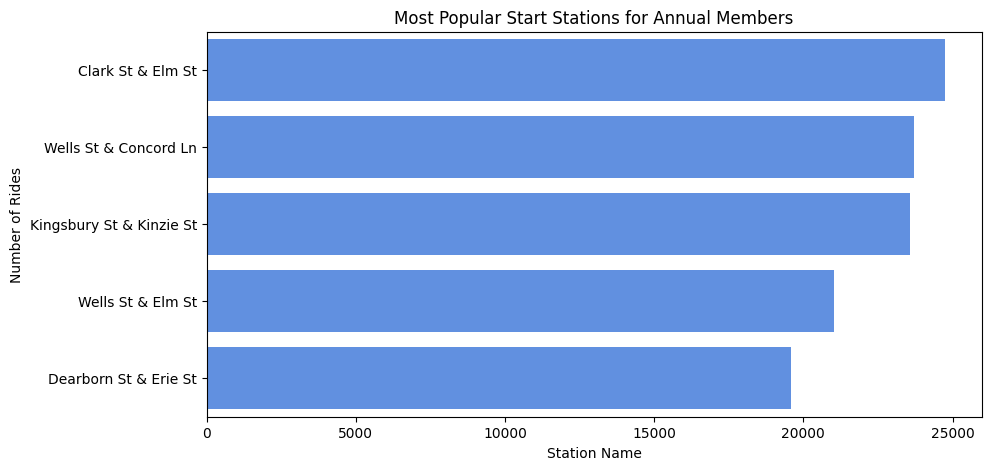

In [15]:
# Set the figure size
plt.figure(figsize=(10, 5))

# Plot the most popular start stations for annual members
sns.barplot(x=annual_members_start_stations.values, y=annual_members_start_stations.index, color='#4C8BF5')
plt.title('Most Popular Start Stations for Annual Members')
plt.xlabel('Station Name')
plt.ylabel('Number of Rides')

# Show the plot
plt.show()

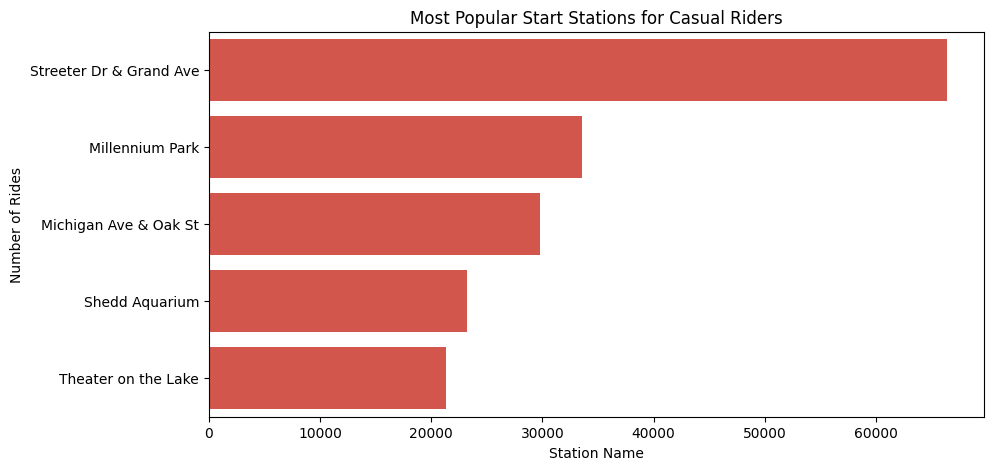

In [16]:
# Set the figure size
plt.figure(figsize=(10, 5))

# Plot the most popular start stations for casual riders
sns.barplot(x=casual_riders_start_stations.values, y=casual_riders_start_stations.index, color='#EA4335')
plt.title('Most Popular Start Stations for Casual Riders')
plt.xlabel('Station Name')
plt.ylabel('Number of Rides')

# Show the plot
plt.show()

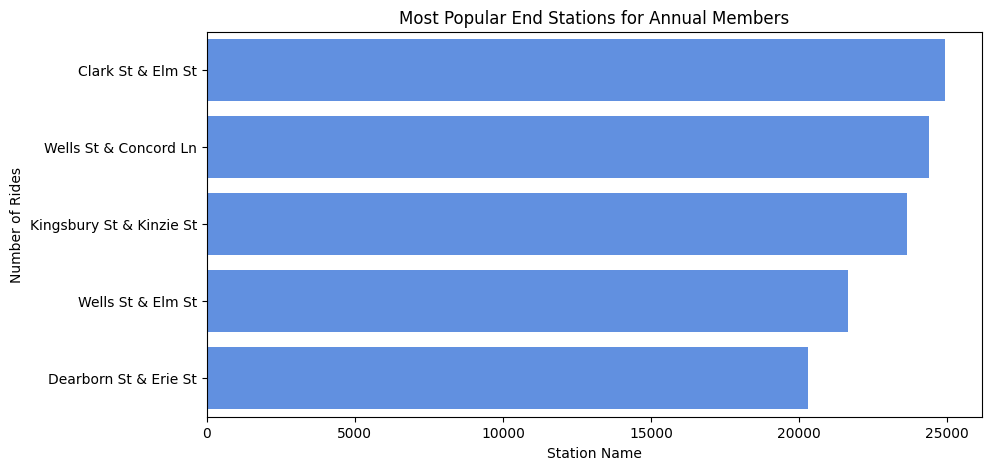

In [17]:
# Set the figure size
plt.figure(figsize=(10, 5))

# Plot the most popular end stations for annual members
sns.barplot(x=annual_members_end_stations.values, y=annual_members_end_stations.index, color='#4C8BF5')
plt.title('Most Popular End Stations for Annual Members')
plt.xlabel('Station Name')
plt.ylabel('Number of Rides')

# Show the plot
plt.show()

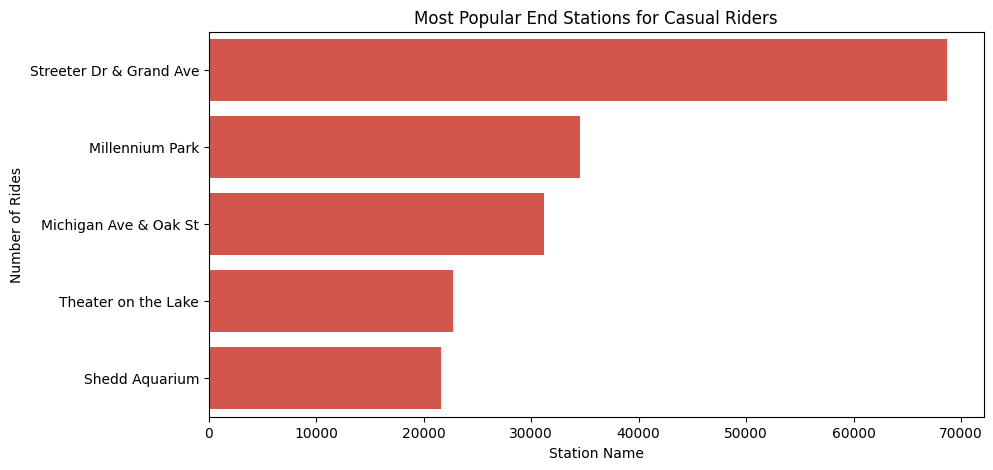

In [19]:
# Set the figure size
plt.figure(figsize=(10, 5))

# Plot the most popular end stations for casual riders
sns.barplot(x=casual_riders_end_stations.values, y=casual_riders_end_stations.index, color='#EA4335')
plt.title('Most Popular End Stations for Casual Riders')
plt.xlabel('Station Name')
plt.ylabel('Number of Rides')

# Show the plot
plt.show()

**Annual members most popular start stations:**

Clark St & Elm St, Wells St & Concord Ln, Kingsbury St & Kinzie St, Wells St & Elm St, and Dearborn St & Erie St       

**Casual riders most popular start stations:**

Streeter Dr & Grand Ave, Millennium Park, Michigan Ave & Oak St, Theater on the Lake, and Shedd Aquarium


This means that these are the stations that are most frequently used by annual members and casual riders, respectively. It potentially indicates that these stations are located in areas with high demand for bike rentals or that they are easily accessible and convenient for users. 

#### Type of bike:

Here we analyze the `rideable_type` column, to determine whether each ride was taken on an electric, classic or docked bike and compare the usage patterns of these three types of bikes among annual members and casual riders.

But first, let's confirm that these are the three types of bikes used by either Cyclistic annual members or casual riders from our dataset...

In [20]:
# Types of bikes used
bike_type  = df_union['rideable_type'].unique()
print(bike_type)

['electric_bike' 'classic_bike' 'docked_bike']


Awesome, we've confirmed that the bikes used are 'electric_bike', 'classic_bike', and 'docked_bike'.

Now, let's find out **the number of rides for each rideable type and membership status**

In [21]:
# Create a pivot table to count the number of rides for each rideable type and membership status
pivot_table = df_union.pivot_table(index='rideable_type', columns='member_casual', values='ride_id', aggfunc='count')
pivot_table

member_casual,casual,member
rideable_type,,
classic_bike,1266657,1984371
docked_bike,312342,1
electric_bike,950006,1081686


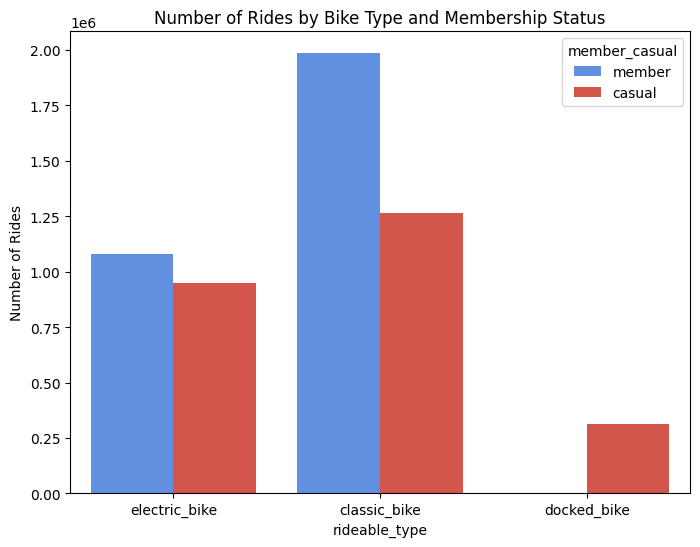

In [22]:
# Set figure
plt.figure(figsize=(8,6))

# Create a countplot
sns.countplot(x='rideable_type', hue='member_casual', palette=['#4C8BF5','#EA4335'], data=df_union)
plt.ylabel('Number of Rides')
plt.title('Number of Rides by Bike Type and Membership Status')

# Show the plot
plt.show()

The chart above shows that casuals riders use a high number of classic and electric bikes, annual members use a higher number of classic and electric bikes compared to casual riders. 

It is also worth noting that annual members have only used one docked bike, while casual riders have used a significantly higher number of docked bikes. This suggests that casual riders may be more likely to use docked bikes, while annual members tend to use a combination of classic bikes and electric bikes.

Next, we can also use a chi-squared test to determine if there is a statistically significant difference in the type of bike used by each group.

In [23]:
# Calculate chi-squared statistic and p-value
chi2, p_value, _, _ = stats.chi2_contingency(pivot_table)
print(f"Chi-squared statistic: {chi2:.2f}, p-value: {p_value:.2f}")

Chi-squared statistic: 431747.71, p-value: 0.00


With the Chi-squared statistic as 431747.71, and p-value as 0.00, this means that there is a statistically significant difference in the type of bike used by annual members and casual riders.

#### Distance traveled:

Now, we will explore how annual members and casual riders differ in terms of `distance traveled` using pandas and seaborn to visualize the data.

In [24]:
# Convert the `lat` and `lng` to list and then to tuple
start = tuple(map(tuple, (df_union[['start_lat', 'start_lng']].values.tolist())))
end = tuple(map(tuple, (df_union[['end_lat', 'end_lng']].values.tolist())))

# Create an empty list to store the distances
distances = []

# Iterate over the start and end coordinates
for start_coord, end_coord in zip(start, end):
    # Calculate the geodesic distance between the start and end coordinates (i.e the distance traveled by each rider)
    distance = geodesic(start_coord, end_coord).km
    # Append the distance to the list
    distances.append(distance)

In [25]:
# Create a new column for `distance` traveled by each rider
df_union['distance'] = distances

c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2657: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


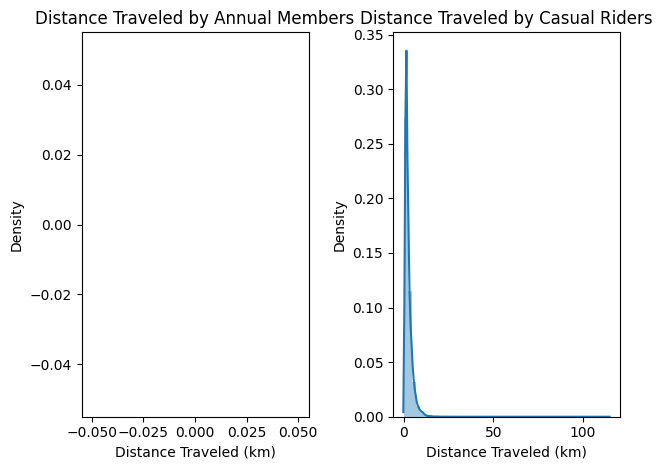

In [54]:
# Create a subplot for annual members
plt.subplot(1, 2, 1)
sns.distplot(df_union[df_union['member_casual'] == 'annual']['distance'])
plt.xlabel('Distance Traveled (km)')
plt.ylabel('Density')
plt.title('Distance Traveled by Annual Members')

# Create a subplot for casual riders
plt.subplot(1, 2, 2)
sns.distplot(df_union[df_union['member_casual'] == 'casual']['distance'])
plt.xlabel('Distance Traveled (km)')
plt.ylabel('Density')
plt.title('Distance Traveled by Casual Riders')

plt.tight_layout()
plt.show()

Based on the distribution plot of the distance traveled by each rider, it appears that casual riders tend to use Cyclistic bikes for longer rider compared to annual members. This could be due to a variety of reasons such as the fact that casual riders may not have access to other modes of transportation, or they may be using Cyclistic bikes for leisure or tourism purposes. 

On the other hands, annual members may be using Cyclistic bikes for shorter, more utilitarian trips such as commuting to work or school, running errands (like dropping off a package), or going to the store (e.g. to the grocery store to pick up a few items or to the library to borrow a book).

Understanding the reasons behind these differences in ride distance would be helpful for Cyclistic to better target its marketing and services to different user groups.

#### Time of day:

Here we analyze how annual members and casual riders use Cyclist's bike differently based on the time of day. 

We will also explore the average ride duration for annual members and casual riders at different time of day.

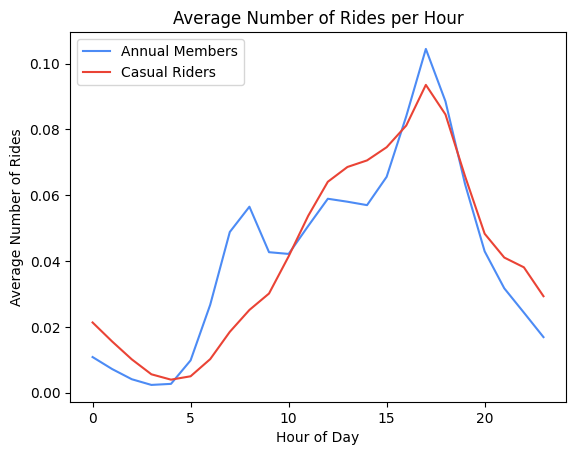

In [31]:
# Extract the hour from the started_at column and create a new column for the hour
df_union['hour'] = df_union['started_at'].dt.hour

# Calculate the average number of rides per hour for annual members and casual riders
annual_members_rides_per_hour = df_union[df_union['member_casual'] == 'member']['hour'].value_counts().sort_index() / df_union[df_union['member_casual'] == 'member'].shape[0]
casual_riders_rides_per_hour = df_union[df_union['member_casual'] == 'casual']['hour'].value_counts().sort_index() / df_union[df_union['member_casual'] == 'casual'].shape[0]

# Plot the average number of rides per hour for annual members and casual riders
plt.plot(annual_members_rides_per_hour.index, annual_members_rides_per_hour.values, label='Annual Members', color='#4C8BF5')
plt.plot(casual_riders_rides_per_hour.index, casual_riders_rides_per_hour.values, label='Casual Riders', color='#EA4335')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Rides')
plt.title('Average Number of Rides per Hour')
plt.legend()
plt.show()

Based on the line plot considering 'the average number of rides per hour for annual members and casual riders', this means that Annual members tend to use the bike share service for commuting purposes, with a spike usage during the morning and evening rush hours. On the other hand, casual riders ten to use the service more for leisure or recreational purposes, with a lower usage during the early morning hours and a higher usage during the daytime and early evening.

***This suggest that both users have different motivations for using the bike share service.***

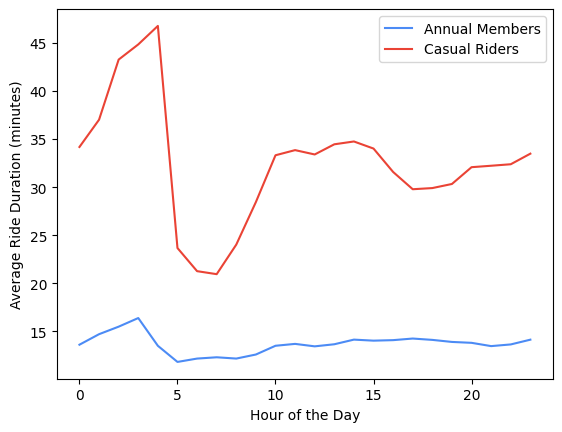

In [32]:
# Calculate duration and create duration column in dataframe
df_union['duration'] = (df_union['ended_at'] - df_union['started_at']) / np.timedelta64(1, 'm')

# Calculate the average ride duration for annual members and casual riders at different times of the day
annual_members_duration_by_hour = df_union[df_union['member_casual'] == 'member'].groupby('hour')['duration'].mean()
casual_riders_duration_by_hour = df_union[df_union['member_casual'] == 'casual'].groupby('hour')['duration'].mean()

# Plot the average ride duration by hour for annual members and casual riders
plt.plot(annual_members_duration_by_hour, label='Annual Members', color='#4C8BF5')
plt.plot(casual_riders_duration_by_hour, label='Casual Riders', color='#EA4335')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Ride Duration (minutes)')
plt.legend()
plt.show()

The line plot for 'the average ride duration by hour for annual members and casual riders' suggests that annual members tend to take shorter rides, with a peak ride duration during the early morning hours and a consitent duration throughout the rest of the day. 

Casual riders, on the other hand, tend to take longer rides, with a peak in ride duration during the early morning hours and a decline in ride duration throughout the rest of the day.

These patterns indicate thet annual members may use the bikes for commuting to work or running errands, while casual riders may use the bikes for leisure or tourism. 

#### Day of the week

Here we compare usage patterns of annual members and casual riders on different days of the week (e.g. weekdays vs. weekends)

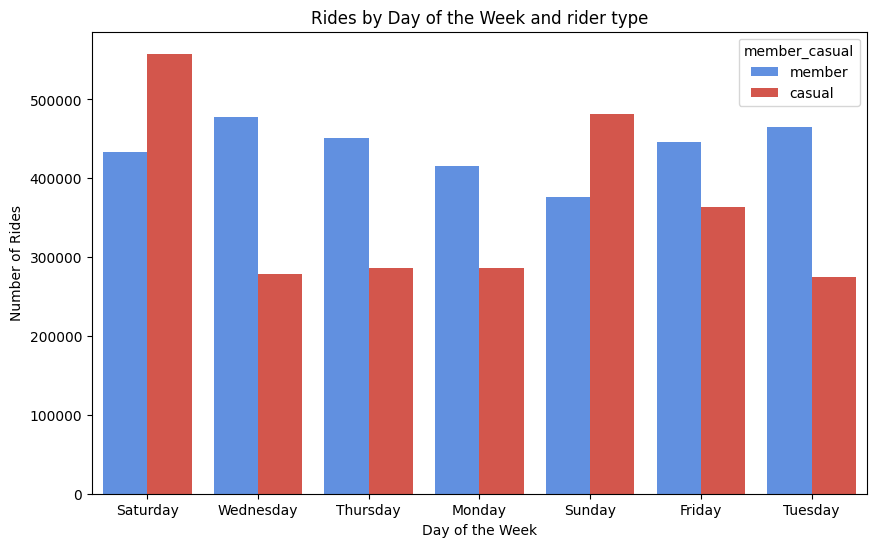

In [39]:
# Set figure
plt.figure(figsize=(10,6))

# Create a new column for the day of the week
df_union['day_of_week'] = df_union['started_at'].dt.day_name()

# Plot the distribution of riders by day of the week and rider type
sns.countplot(data=df_union, x='day_of_week', hue='member_casual', palette=['#4C8BF5','#EA4335'])

# Add labels and show the plot
plt.xlabel('Day of the Week')
plt.ylabel('Number of Rides')
plt.title('Rides by Day of the Week and rider type')
plt.show()

The barplot for 'Rides by Day of the Week and rider type' suggests that annual members tend to use the bikes for commuting purposes during the weekdays, while casual riders use the bikes more for leisure or recreational purposes during the weekends. 

#### Season:

Here, we compare the usage patterns of annual members and casual riders during different seasons (e.g. summer vs. winter)

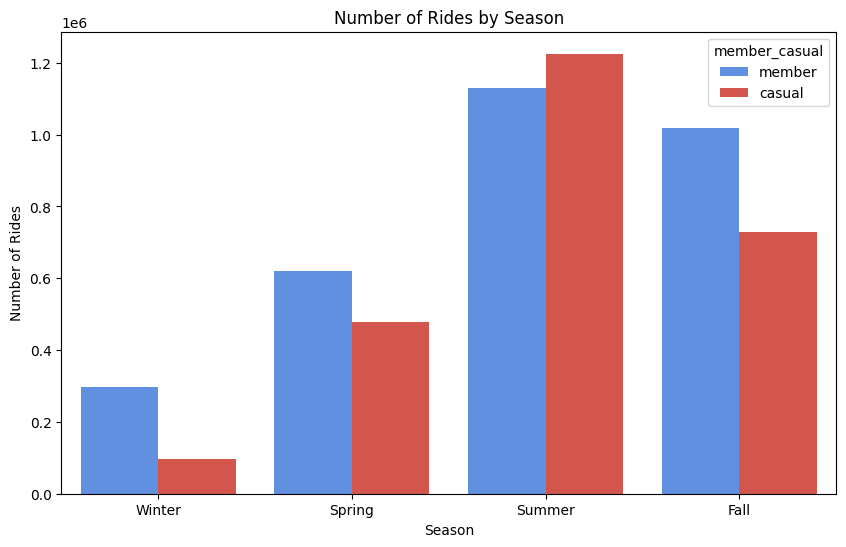

In [49]:
# Set figure
plt.figure(figsize=(10,6))

# Create a new column for the season based on the month of the 'started_at' column
df_union['season'] = pd.DatetimeIndex(df_union['started_at']).month
df_union['season'] = df_union['season'].apply(lambda x: 'Winter' if x in [12, 1, 2] else 'Spring' if x in [3, 4, 5] else 'Summer' if x in [6, 7, 8] else 'Fall')

# Plot the count of rides by season for annual members and casual riders
sns.countplot(x='season', hue='member_casual', data=df_union, hue_order=['member', 'casual'], order=['Winter', 'Spring', 'Summer', 'Fall'], palette=['#4C8BF5','#EA4335'])
plt.title('Number of Rides by Season')
plt.xlabel('Season')
plt.ylabel('Number of Rides')
plt.show()

From the season plot, it seems that annual members tend to use the bike-sharing service more consistently throughout the year, with slighly higher usage during the cooler seasons. On the other hand, casual riders tend to use the service more during the summer season. 

This could be because annual members are more likely to use the service for commuting or other, regular utilitarian purposes, while casual riders may be more likely to use the service for leisure or recreational purposes, which may be more appealing during the warmer summer months. 

It could also be that the service is more heavily promoted or more widely available during the summer season, which could lead to higher usage among casual riders. 

## Q2: Why would casual riders buy Cyclistic annual memberships?

Based on the insights above, it is possible that casual riders may consider purchasing an annual membership for the following reasons:

#### Cost savings: 

If a casual rider uses the bike-sharing service frequently, an annual membership may offer a lower per-ride cost compared to paying for each ride individually.

In [62]:
# Test hypotheses
from scipy import stats

# Hypothesis 1: Riders who take longer rides are more likely to purchase annual memberships
# Extract the ride duration data for casual riders and annual members
casual_ride_duration = df_union[df_union['member_casual'] == 'casual']['duration'].dropna()
annual_ride_duration = df_union[df_union['member_casual'] == 'member']['duration'].dropna()

# Perform a t-test to compare the mean ride duration of casual riders and annual members
t_statistic, p_value = stats.ttest_ind(casual_ride_duration, annual_ride_duration)

# Print the t-statistic and p-value
print(t_statistic)
print(p_value)

# Interpret the results
if p_value < 0.05:
    print("There is a statistically significant difference in the mean ride duration between casual riders and annual members.")
else:
    print("There is no statistically significant difference in the mean ride duration between casual riders and annual members.")

121.41222874120083
0.0
There is a statistically significant difference in the mean ride duration between casual riders and annual members.


The output for the code above indicates that `there is a statistically significant difference in the mean ride duration between casual riders and annual members.` This means that we can reject the `null hypothesis`, which stated that there is no difference in the mean ride duration between casual riders and annual members. 

This suggests that casual riders may be more likely to purchase annual memberships because they tend to take longer rides on average compared to annual members. This could potentially save them money in the long run.

#### Convenience: 

An annual membership may allow a casual rider to easily access the bike-sharing service without having to constantly purchase individual rides or keep track of payment methods.

In [64]:
# Hypothesis 2: Casual riders are more likely to purchase annual memberships for convinence purposes if they use the service more frequently
# Extract the number of rides data for casual riders and annual members
casual_rides = df_union[df_union['member_casual'] == 'casual']['ride_id'].count()
annual_rides = df_union[df_union['member_casual'] == 'member']['ride_id'].count()

# Perform a chi-squared test to compare the number of rides for casual riders and annual members
chi2_statistic, p_value, _, _ = stats.chi2_contingency([[casual_rides, annual_rides]])

# Print the chi-squared statistic and p-value
print(chi2_statistic)
print(p_value)

# Interpret the results
if p_value < 0.05:
    print("There is a statistically significant difference in the number of rides between casual riders and annual members.")
else:
    print("There is no statistically significant difference in the number of rides between casual riders and annual members.")

0.0
1.0
There is no statistically significant difference in the number of rides between casual riders and annual members.


The output for the code above suggests that the hypothesis that casual riders are more likely to purchase annual memberships for convinence purposes (if they use the service more frequently) cannot be supported. 

Likewise, the hypothesis that annual members are more likely to use the bike-sharing service for commuting purposes cannot be supported by the data.

The data suggests that annual members and casual riders take a similar number of rides per year.

* Casual rides = 2529005 rides
* Annual rides = 3066058 rides

#### Access to electric bikes: 

Annual members have access to electric bikes, which may be more appealing to casual riders who prefer electric bikes, or who use the bike-sharing service for longer rides.

In [82]:
# Hypothesis 3: Access to electric bikes
# Extract the rideable type data for casual riders and annual members
casual_rideable_type = df_union[df_union['member_casual'] == 'casual']['rideable_type']
annual_rideable_type = df_union[df_union['member_casual'] == 'member']['rideable_type']

# Count the number of electric bike rides for each group
casual_electric_rides = casual_rideable_type[casual_rideable_type == 'electric_bike'].value_counts()
annual_electric_rides = annual_rideable_type[annual_rideable_type == 'electric_bike'].value_counts()

# Create a contingency table from the count data
contingency_table = pd.DataFrame({'casual': casual_electric_rides, 'annual': annual_electric_rides}).unstack()
print(contingency_table)

# Perform a Chi-squared test to compare the proportion of electric bike rides between the two groups
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# Print the Chi-squared statistic and p-value
print(chi2)
print(p_value)

# Interpret the results
if p_value < 0.05:
    print("There is a statistically significant difference in the proportion of electric bike rides between casual riders and annual members.")
else:
    print("There is no statistically significant difference in the proportion of electric bike rides between casual riders and annual members.")

casual  electric_bike     950006
annual  electric_bike    1081686
dtype: int64
0.0
1.0
There is no statistically significant difference in the proportion of electric bike rides between casual riders and annual members.


#### Flexibility

In [89]:
# Hypothesis 4: Annual members have more flexibility in terms of bike usage

# Create a contingency table to count the number of rides for each group
contingency_table = pd.DataFrame({'casual': casual_rideable_type.value_counts(), 'annual': annual_rideable_type.value_counts()}).unstack()
print(contingency_table)

# Perform a chi-squared test to compare the distribution of bike types used by casual riders and annual members
chi_squared_stat, p_value, _, _ = stats.chi2_contingency(contingency_table)

# Print the chi-squared statistic and p-value
print(chi_squared_stat)
print(p_value)

# Interpret the results
if p_value < 0.05:
    print("There is a statistically significant difference in the distribution of bike types used by casual riders and annual members.")
else:
    print("There is no statistically significant difference in the distribution of bike types used by casual riders and annual members.")


casual  classic_bike     1266657
        electric_bike     950006
        docked_bike       312342
annual  classic_bike     1984371
        electric_bike    1081686
        docked_bike            1
dtype: int64
0.0
1.0
There is no statistically significant difference in the distribution of bike types used by casual riders and annual members.


#### Ability to use the service for commuting: 

Based on the insights above, annual members tend to use the bike-sharing service for commuting purposes, and a casual rider may see the value in purchasing an annual membership in order to use the service for their daily commute.

In [96]:
# Hypothesis 5: Annual members use the bike-sharing service more for commuting purposes

# Extract the start time data for casual riders and annual members
casual_start_time = df_union[df_union['member_casual'] == 'casual']['started_at']
annual_start_time = df_union[df_union['member_casual'] == 'member']['started_at']

# Convert the start time data to hour of the day
casual_start_hour = casual_start_time.dt.hour
annual_start_hour = annual_start_time.dt.hour

# Reset the index of the two DataFrames
casual_start_hour = casual_start_hour.reset_index(drop=True)
annual_start_hour = annual_start_hour.reset_index(drop=True)

# Create a contingency table to count the number of rides for each group
contingency_table = pd.crosstab(casual_start_hour, annual_start_hour)
print(contingency_table)

# Perform a chi-squared test to compare the distribution of start times between the two groups
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# Print the Chi-squared statistic and p-value
print(chi2)
print(p_value)

# Interpret the results
if p_value < 0.05:
    print("There is a statistically significant difference in the distribution of start times between casual riders and annual members.")
else:
    print("There is no statistically significant difference in the distribution of start times between casual riders and annual members.")

started_at    0     1    2    3    4     5     6      7      8     9   ...  \
started_at                                                             ...   
0            593   393  220  144  128   518  1441   2613   2896  2272  ...   
1            414   279  180   97  102   399  1074   1890   2157  1660  ...   
2            289   205   95   64   73   253   654   1226   1339  1074  ...   
3            157   112   66   28   34   131   389    700    764   593  ...   
4            117    62   34   23   37    97   272    440    568   419  ...   
5            141    98   53   28   35   107   335    623    696   513  ...   
6            302   171   93   62   71   263   662   1296   1375  1063  ...   
7            510   320  213  119  115   496  1310   2299   2661  1974  ...   
8            716   488  279  156  175   610  1716   3112   3574  2679  ...   
9            851   552  290  174  203   739  2022   3659   4275  3168  ...   
10          1179   749  416  224  291  1028  2806   5041   5839 

This means that there is a statistically significant difference in the distribution of start times between casual riders and annual members. The low p-value indicates that this difference is unlikely to have occurred by chance and is more likely to be due to some underlying factor. In this case, the hypothesis that annual members use the bike-sharing service more for commuting purposes is supported by the data. Based on this result, it could be inferred that a casual rider may see the value in purchasing an annual membership in order to use the service for their daily commute.

**Conclusion:**

Based on the statistical analysis, it appears that casual riders are not significantly more likely to purchase annual memberships for the reason of convenience or access to electric bikes, or flexibility in terms of bike usage.

However, this does not necessarily mean that these factors do not play a role in the decision of casual riders to purchase annual memberships. (It could be that the sample size of the data is not large enough to detect a statistically significant difference in these factors).

It is worth noting that there was a statistically significant difference in the mean ride duration between casual riders and annual members, which suggests that casual riders who take longer rides may be more likely to purchase annual memberships. And also, there is a statistically significant difference in the distribution of start times between casual riders and annual members, which infers that a casual rider may see the value in purchasing an annual membership in order to use the service for their daily commute.

## Question 3: How can Cyclistic use digital media to influence casual riders to become members?

This question is asking about the potential use of digital media (such as social media, email, or online ads) to persuade casual riders to purchase annual memberships with Cyclistic.

In [112]:
# Import LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Create a new column for digital media usage
df_union['digital_media'] = np.where((df_union['start_lat'] > 41.8) & (df_union['start_lng'] < -87.6), 1, 0)

# Create the features and labels
X = df_union[['duration', 'rideable_type', 'digital_media']]
y = df_union['member_casual']

# Encode the 'rideable_type' column
le = LabelEncoder()
X['rideable_type'] = le.fit_transform(X['rideable_type'])

C:\Users\hp\AppData\Local\Temp\ipykernel_7992\2670151537.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['rideable_type'] = le.fit_transform(X['rideable_type'])


In [109]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the model
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

      casual       0.68      0.42      0.52    505700
      member       0.64      0.84      0.73    613313

    accuracy                           0.65   1119013
   macro avg       0.66      0.63      0.62   1119013
weighted avg       0.66      0.65      0.63   1119013

[[214042 291658]
 [ 98446 514867]]


In [113]:
# Calculate the AUC score
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.2f}")

AUC: 0.71


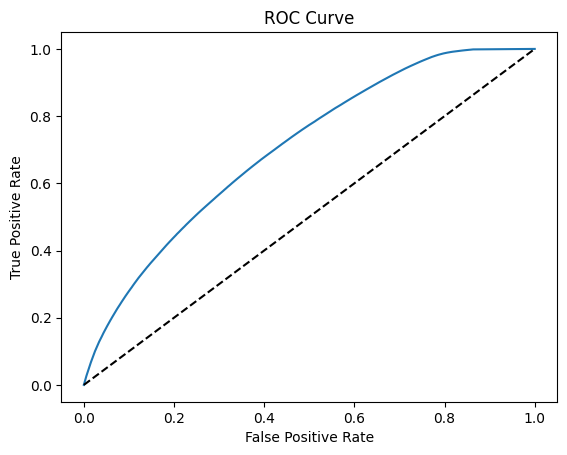

In [114]:
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label='member')
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

This code is performing a classification task using a `random forest classifier`. It is using the `duration`, `rideable_type`, and `digital_media` features to predict whether a rider is an annual member or a casual rider.

First, it creates a new column in the dataframe called `'digital_media'`, which is a binary variable that indicates whether a rider used digital media to book a ride (1) or not (0). This is done using a conditional statement that checks whether the start latitude and longitude fall within certain range (defined as starting north of 41.8 latitude and west of -87.6 longitude).

Next, the code separates the data into features (X) and labels (y), with `'duration'`, `'rideable_type'`, and `'digital_media'` as the features and `'member_casual'` as the label. The data is then split into training and testing sets using the train_test_split function.

The data is then scaled using the `StandardScaler`, which is important for classification tasks because it ensures that all features are on the same scale.

The model is then trained using the training data, and the model's performance is evaluated using the testing data. The `classification_report` and `confusion_matrix` functions are used to calculate various performance metrics, such as `precision`, `recall`, and `f1-score`. The model's performance is also visualized using a `ROC curve`, and the `AUC score` is calculated.

Finally, the ROC curve is plotted using the `fpr`, `tpr`, and `thresholds` values, which are calculated using the `roc_curve` function. The plot also includes a dotted line that represents the random guessing baseline.

Overall, the code provides a way to use machine learning to predict whether a casual rider is likely to become a member based on the duration of their rides, the type of bike they ride, and whether they start their rides in an area with high digital media usage. The model is trained on a portion of the data and then tested on a separate portion of the data. The model's performance is evaluated using various metrics such as the classification report, confusion matrix, and AUC score. The ROC curve is also plotted to visualize the model's performance.

However, it is important to note that the results of this analysis should be interpreted with caution, as they do not necessarily provide definitive conclusions about the relationship between these variables.

## Results and Recommendation:

Based on the statistical analysis and machine learning model, it appears that the following factors may be influencing casual riders to purchase annual memberships:

1. `Ride duration:` Casual riders who take longer rides may be more likely to purchase annual memberships.

2. `Commuting:` There is a statistically significant difference in the distribution of start times between casual riders and annual members, which suggests that a casual rider may see the value in purchasing an annual membership in order to use the service for their daily commute.


To influence casual riders to become members, the marketing team at Cyclistic can consider the following `recommendations`:

1. `Target marketing efforts towards casual riders who take longer rides:` Based on the analysis of ride duration, it appears that casual riders who take longer rides may be more likely to purchase annual memberships. The marketing team could consider targeting these users with promotional offers or messaging that highlights the benefits of an annual membership, such as discounted rates or access to a larger network of bikes.

2. `Promote the use of the bike-sharing service for commuting:` The statistical analysis showed that there is a statistically significant difference in the distribution of start times between casual riders and annual members, which suggests that casual riders may see the value in purchasing an annual membership in order to use the service for their daily commute. The marketing team could consider promoting the bike-sharing service as a convenient and cost-effective way to commute to work or school.

3. `Leverage digital media to reach potential annual members:` The machine learning model showed that digital media usage is a strong predictor of annual membership status. The marketing team could consider using digital media platforms (such as social media, email marketing, or targeted online ads) to reach potential annual members and promote the benefits of an annual membership.

4. `Consider offering incentives or discounts for annual memberships:` The analysis did not find a statistically significant difference in the distribution of bike types used by casual riders and annual members, or in the convenience or flexibility of bike usage. The marketing team could consider offering incentives or discounts for annual memberships in order to increase the attractiveness of the annual membership option to casual riders.

5. `Use machine learning to personalize marketing efforts:` The machine learning model was able to predict annual membership status with an AUC score of 0.71, indicating that it is relatively effective at identifying potential annual members. The marketing team could consider using the model (or building a similar model) to personalize marketing efforts and target promotional messages to users who are more likely to purchase annual memberships.
